# Fundamentos de Inteligência Artificial - Trabalho Prático 2

## Problema - Coloração de Grafos: 

O problema de coloração em grafos em sua forma mais tradicional consiste na rotulação (atribuição de uma cor) de vértices de um grafo, os quais estão sujeitos a restrições previamente definidas. A restrição usualmente imposta é que dois vértices vizinhos, isto é, que compartilham uma mesma aresta, não podem possuir a mesma cor.

Neste notebook, uma instância desse problema é modelada como um grafo de restrições (Constraint Graph), onde as arestas representam as restrições binárias entre os vértices (variáveis do problema). Para construir este grafo, utilizaremos a mesma estrutura de dados (class Graph) que foi fornecida no Estudo Dirigido 1 sobre Busca em Grafos.

In [1]:
import time
import pandas as pd
import os
import matplotlib.pyplot as plt
import random
import math
import numpy as np

In [2]:
class Edge:
    def __init__(self, u, v, w):
        self.u = u  # starting vertex
        self.v = v  # ending vertex
        self.w = w  # weight of the edge

    def __lt__(self, other):
        # This makes the edges comparable by weight for sorting
        return self.w < other.w

    def __str__(self):
        # String representation of an edge
        return f"{self.u} -> {self.v} ({self.w})"

    def __repr__(self):
        return self.__str__()

class Graph:
    def __init__(self):
        # Initialize a graph with no predefined number of vertices
        self.graph = {}  # key: vertex, value: list of edges

    def add_edge(self, u, v, w):
        # Add an edge from u to v with weight w
        if u not in self.graph:
            self.graph[u] = []
        if v not in self.graph:
            self.graph[v] = []

        self.graph[u].append(Edge(u, v, w))

    def add_undirected_edge(self, u, v, w):
        # Add an undirected edge between u and v with weight w
        self.add_edge(u, v, w)
        self.add_edge(v, u, w)

    def __str__(self):
        # String representation of the entire graph
        result = []
        for u in self.graph:
            for edge in self.graph[u]:
                result.append(str(edge))
        return "\n".join(result)

    def get_edges(self):
        # Returns all edges in the graph
        edges = []
        for u in self.graph:
            for edge in self.graph[u]:
                edges.append(edge)
        return edges

    def out_degree(self, u):
        # Return the out-degree of vertex u
        if u in self.graph:
            return len(self.graph[u])
        else:
            raise ValueError(f"Vertex {u} not found in the graph.")

    def in_degree(self, v):
        # Return the in-degree of vertex v
        in_deg = 0
        for u in self.graph:
            for edge in self.graph[u]:
                if edge.v == v:
                    in_deg += 1
        return in_deg

    def get_neighbors(self, u):
        # Returns the neighbors of vertex u
        if u in self.graph:
            return [edge.v for edge in self.graph[u]]
        else:
            raise ValueError(f"Vertex {u} not found in the graph.")

### Instância do Problema de Coloração em Grafos: 

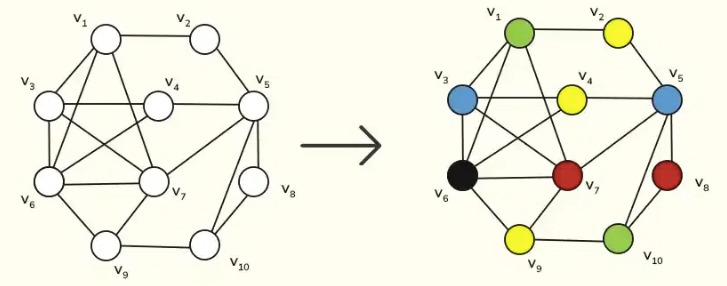

In [3]:
Example = Graph()

Example.add_undirected_edge("V1", "V2", 1)
Example.add_undirected_edge("V1", "V3", 1)
Example.add_undirected_edge("V1", "V6", 1)
Example.add_undirected_edge("V1", "V7", 1)
Example.add_undirected_edge("V2", "V5", 1)
Example.add_undirected_edge("V3", "V4", 1)
Example.add_undirected_edge("V3", "V6", 1)
Example.add_undirected_edge("V3", "V7", 1)
Example.add_undirected_edge("V4", "V5", 1)
Example.add_undirected_edge("V4", "V6", 1)
Example.add_undirected_edge("V5", "V7", 1)
Example.add_undirected_edge("V5", "V8", 1)
Example.add_undirected_edge("V5", "V10", 1)
Example.add_undirected_edge("V6", "V7", 1)
Example.add_undirected_edge("V6", "V9", 1)
Example.add_undirected_edge("V8", "V10", 1)
Example.add_undirected_edge("V9", "V10", 1)

In [4]:
print(Example)

V1 -> V2 (1)
V1 -> V3 (1)
V1 -> V6 (1)
V1 -> V7 (1)
V2 -> V1 (1)
V2 -> V5 (1)
V3 -> V1 (1)
V3 -> V4 (1)
V3 -> V6 (1)
V3 -> V7 (1)
V6 -> V1 (1)
V6 -> V3 (1)
V6 -> V4 (1)
V6 -> V7 (1)
V6 -> V9 (1)
V7 -> V1 (1)
V7 -> V3 (1)
V7 -> V5 (1)
V7 -> V6 (1)
V5 -> V2 (1)
V5 -> V4 (1)
V5 -> V7 (1)
V5 -> V8 (1)
V5 -> V10 (1)
V4 -> V3 (1)
V4 -> V5 (1)
V4 -> V6 (1)
V8 -> V5 (1)
V8 -> V10 (1)
V10 -> V5 (1)
V10 -> V8 (1)
V10 -> V9 (1)
V9 -> V6 (1)
V9 -> V10 (1)


***
### Implementação da Função contar_conflitos(grafo, coloracao). 

#### Entrada:

- o grafo (objeto da classe Graph)

- um dicionário coloracao, onde coloracao[vértice] = cor atribuída

#### Saída:

- número total de conflitos (arestas entre vértices de mesma cor)

In [5]:
def contar_conflitos(grafo, coloracao):
    conflitos = 0
    visitados = set()

    for u in grafo.graph:
        for vizinho in grafo.get_neighbors(u):
            if (u, vizinho) not in visitados and (vizinho, u) not in visitados:
                if coloracao[u] == coloracao[vizinho]:
                    conflitos += 1
                visitados.add((u, vizinho))
                visitados.add((vizinho, u))

    return conflitos

#### Explicação rápida:

- Percorremos todas as arestas do grafo.

- Para cada par (u, vizinho), verificamos se já contamos esse par (usando o conjunto visitados).

- Se os dois vértices tiverem a mesma cor, incrementamos o contador de conflitos.

Essa função será útil para guiar as heurísticas de busca que implementaremos a seguir. Vamos agora testar se ela funciona, passando como argumento uma coloração, ou seja, uma atribuição de cores a cada vértice na forma de um dicionário:

In [6]:
coloracao_exemplo = {
    "V1": "vermelho",
    "V2": "azul",
    "V3": "vermelho",
    "V4": "amarelo",
    "V5": "azul",
    "V6": "verde",  
    "V7": "vermelho",
    "V8": "azul",
    "V9": "verde",
    "V10": "vermelho"
}

print("Conflitos:", contar_conflitos(Example, coloracao_exemplo))

Conflitos: 6


***
### Implementação da Função que gera uma atribuição (coloração) aleatória. 
- serve para gerar uma atribuição inicial para o problema de coloração de grafos.
- Entrada: Grafo de restrições e lista de possíveis cores para seus vértices.
- Saída: dicionário -> key: vertice, value: cor


In [7]:
def gerar_coloracao_aleatoria(grafo, cores=["vermelho", "azul", "verde", "amarelo"], greedy=False):
    if not greedy:
        coloracao = {}
        for vertice in grafo.graph.keys():
            coloracao[vertice] = random.choice(cores)
        return coloracao

    coloracao = {}
    vertices = list(grafo.graph.keys())
    random.shuffle(vertices)

    for v in vertices:
        vizinhos = grafo.get_neighbors(v)
        cores_vizinhos = {coloracao[u] for u in vizinhos if u in coloracao}
        disponiveis = [c for c in cores if c not in cores_vizinhos]
        if disponiveis:
            coloracao[v] = disponiveis[0]
        else:
            def conflitos_locais(c):
                return sum(1 for u in vizinhos if coloracao.get(u) == c)
            coloracao[v] = min(cores, key=conflitos_locais)

    return coloracao


In [8]:
# Gerar uma coloração aleatória
coloracao_aleatoria = gerar_coloracao_aleatoria(Example)

# Mostrar a coloração gerada
print("Coloração Aleatória:")
for vertice, cor in coloracao_aleatoria.items():
    print(f"{vertice}: {cor}")

# Contar conflitos
num_conflitos = contar_conflitos(Example, coloracao_aleatoria)
print("\nNúmero de conflitos:", num_conflitos)

Coloração Aleatória:
V1: verde
V2: azul
V3: amarelo
V6: azul
V7: amarelo
V5: vermelho
V4: vermelho
V8: vermelho
V10: verde
V9: amarelo

Número de conflitos: 3


# Heurísticas

Nesta etapa, você deverá implementar algumas heurísticas de busca para resolver o problema de coloração.

***

### Implementação das Heurísticas:

#### Random Walk (RW)
- Escolhe aleatoriamente uma variável e muda sua cor aleatoriamente.
- Se melhorar (reduzir conflitos), aceita.
- Senão, também pode aceitar (não é obrigatório ser só melhoria, você pode definir uma probabilidade mais baixa para aceitar pioras).

In [9]:
def random_walk(grafo, coloracao_inicial, cores, max_iter=1000):
    coloracao = coloracao_inicial.copy()
    conflitos = contar_conflitos(grafo, coloracao)
    prob_aceitar_pior = 0.1

    for _ in range(max_iter):
        solucao_vizinha = coloracao.copy()
        vertices = list(grafo.graph.keys())
        vertice = random.choice(vertices)

        cor_atual = solucao_vizinha[vertice]
        cores_possiveis = []
        for cor in cores:
            if cor != cor_atual:
                cores_possiveis.append(cor)
        nova_cor = random.choice(cores_possiveis)

        solucao_vizinha[vertice] = nova_cor
        novos_conflitos = contar_conflitos(grafo, solucao_vizinha)

        if novos_conflitos < conflitos:
            coloracao = solucao_vizinha
            conflitos = novos_conflitos
        else:
            if random.random() < prob_aceitar_pior:
                coloracao = solucao_vizinha
                conflitos = novos_conflitos

        if conflitos == 0:
            break

    return coloracao, conflitos


#### Best Improvement (BI)
- Testa TODAS as mudanças possíveis (todos vértices e cores).
- Escolhe a mudança que mais reduz conflitos.

In [10]:
def best_improvement(grafo, coloracao_inicial, cores, max_iter=1000):
    coloracao = coloracao_inicial.copy()
    conflitos = contar_conflitos(grafo, coloracao)

    for _ in range(max_iter):
        melhor_coloracao = coloracao.copy()
        melhor_conflito = conflitos

        for vertice in grafo.graph.keys():
            cor_atual = coloracao[vertice]

            for cor in cores:
                if cor == cor_atual:
                    continue

                solucao_vizinha = coloracao.copy()
                solucao_vizinha[vertice] = cor
                novos_conflitos = contar_conflitos(grafo, solucao_vizinha)

                if novos_conflitos < melhor_conflito:
                    melhor_coloracao = solucao_vizinha
                    melhor_conflito = novos_conflitos

        if melhor_conflito < conflitos:
            coloracao = melhor_coloracao
            conflitos = melhor_conflito
        else:
            break

        if conflitos == 0:
            break

    return coloracao, conflitos


#### First Improvement with Random Local Search (FI-RS):
- Escolhe uma variável aleatoriamente.
- Tenta uma cor aleatória para ela.
- Se melhorar, aceita.

In [11]:
def first_improvement_rs(grafo, coloracao_inicial, cores, max_iter=1000):
    coloracao = coloracao_inicial.copy()
    conflitos = contar_conflitos(grafo, coloracao)

    for _ in range(max_iter):
        vertice = random.choice(list(grafo.graph.keys()))

        cor_atual = coloracao[vertice]
        cores_possiveis = [c for c in cores if c != cor_atual]
        nova_cor = random.choice(cores_possiveis)

        nova_coloracao = coloracao.copy()
        nova_coloracao[vertice] = nova_cor

        novos_conflitos = contar_conflitos(grafo, nova_coloracao)

        if novos_conflitos < conflitos:
            coloracao = nova_coloracao
            conflitos = novos_conflitos

        if conflitos == 0:
            break

    return coloracao, conflitos


#### First Improvement com Any Conflict (FI with AC):
- Escolhe aleatoriamente uma variável que está em conflito.
- Tenta todas as cores possíveis para ela.
- Escolhe a cor que mais reduz conflitos (best color para aquela variável).

In [12]:
def get_vertices_em_conflito(grafo, coloracao):
    visitados = set()
    conflitantes = set()
    for u in grafo.graph:
        for vizinho in grafo.get_neighbors(u):
            if (u, vizinho) not in visitados and (vizinho, u) not in visitados:
                if coloracao[u] == coloracao[vizinho]:
                    conflitantes.add(u)
                    conflitantes.add(vizinho)
                visitados.add((u, vizinho))
                visitados.add((vizinho, u))
    return conflitantes


def first_improvement_ac(grafo, coloracao_inicial, cores, max_iter=1000):
    coloracao = coloracao_inicial.copy()
    conflitos = contar_conflitos(grafo, coloracao)

    for _ in range(max_iter):
        vertices_conflitantes = get_vertices_em_conflito(grafo, coloracao)
        if not vertices_conflitantes:
            break

        vertice = random.choice(list(vertices_conflitantes))
        melhor_cor = coloracao[vertice]
        melhor_conflito = conflitos

        for cor in cores:
            if cor == coloracao[vertice]:
                continue
            nova_coloracao = coloracao.copy()
            nova_coloracao[vertice] = cor
            novos_conflitos = contar_conflitos(grafo, nova_coloracao)
            if novos_conflitos < melhor_conflito:
                melhor_cor = cor
                melhor_conflito = novos_conflitos

        if melhor_conflito < conflitos:
            coloracao[vertice] = melhor_cor
            conflitos = melhor_conflito

        if conflitos == 0:
            break

    return coloracao, conflitos



#### Simulated Annealing (SA)
- Parecido com FI, mas aceita piores soluções com uma probabilidade que diminui com o tempo (controle de temperatura).

In [13]:
def simulated_annealing(grafo, coloracao_inicial, cores, max_iter=1000, temperatura_inicial=1000, taxa_resfriamento=0.995):
    coloracao = coloracao_inicial.copy()
    conflitos = contar_conflitos(grafo, coloracao)
    temperatura = temperatura_inicial

    for _ in range(max_iter):
        solucao_vizinha = coloracao.copy()
        vertices = list(grafo.graph.keys())
        vertice = random.choice(vertices)

        cor_atual = solucao_vizinha[vertice]
        cores_possiveis = []
        for cor in cores:
            if cor != cor_atual:
                cores_possiveis.append(cor)
        nova_cor = random.choice(cores_possiveis)

        solucao_vizinha[vertice] = nova_cor
        novos_conflitos = contar_conflitos(grafo, solucao_vizinha)
        delta = novos_conflitos - conflitos

        if delta < 0:
            coloracao = solucao_vizinha
            conflitos = novos_conflitos
        else:
            prob_aceitar = math.exp(-delta / temperatura)
            if random.random() < prob_aceitar:
                coloracao = solucao_vizinha
                conflitos = novos_conflitos

        temperatura *= taxa_resfriamento

        if conflitos == 0 or temperatura < 1e-6:
            break

    return coloracao, conflitos


#### Algoritmo Genético (GA)
- Evolui um conjunto de soluções candidatas, denominado população;
- A cada passo, as soluções atuais interagem entre si, através dos operadores de recombinação (crossover) e mutação (mutation) para produzir uma nova população. 

In [14]:
def criar_populacao_inicial(grafo, num_individuos, cores_disponiveis):
    populacao = []
    for _ in range(num_individuos):
        individuo = {}
        for vertice in grafo.graph.keys():
            individuo[vertice] = random.choice(cores_disponiveis)
        populacao.append(individuo)
    return populacao


def calcula_fitness(individuo, grafo):
    return contar_conflitos(grafo, individuo)


def selecao_com_annealing(populacao, grafo, temperatura):
    custos = [calcula_fitness(individuo, grafo) for individuo in populacao]
    pesos = [math.exp(-custo / temperatura) for custo in custos]
    soma_pesos = sum(pesos)
    if soma_pesos == 0:
        pesos_normalizados = [1 / len(populacao)] * len(populacao)
    else:
        pesos_normalizados = [p / soma_pesos for p in pesos]
    indice = random.choices(range(len(populacao)), weights=pesos_normalizados, k=1)[0]
    return indice


def crossover(pai1, pai2):
    vertices = list(pai1.keys())
    ponto_corte = random.randint(1, len(vertices) - 1)
    filho1 = {}
    filho2 = {}

    for i in range(len(vertices)):
        vertice = vertices[i]
        if i < ponto_corte:
            filho1[vertice] = pai1[vertice]
            filho2[vertice] = pai2[vertice]
        else:
            filho1[vertice] = pai2[vertice]
            filho2[vertice] = pai1[vertice]

    return filho1, filho2


def mutation(individuo, cores, taxa_mutacao):
    novo_individuo = individuo.copy()
    for vertice in individuo.keys():
        if random.random() < taxa_mutacao:
            cor_atual = individuo[vertice]
            cores_possiveis = []
            for cor in cores:
                if cor != cor_atual:
                    cores_possiveis.append(cor)
            nova_cor = random.choice(cores_possiveis)
            novo_individuo[vertice] = nova_cor
    return novo_individuo

In [15]:
def algoritmo_genetico(grafo, num_individuos, num_geracoes, cores, taxa_mutacao, temperatura_inicial, taxa_resfriamento):
    populacao = criar_populacao_inicial(grafo, num_individuos, cores)
    temperatura = temperatura_inicial
    melhor_global_individuo = None                     
    melhor_global_fitness = float('inf')               

    for geracao in range(num_geracoes):
        populacao_fitness = [calcula_fitness(individuo, grafo) for individuo in populacao]
        melhor_indice = populacao_fitness.index(min(populacao_fitness))
        melhor_individuo = populacao[melhor_indice]
        melhor_fitness = populacao_fitness[melhor_indice]

        if melhor_fitness < melhor_global_fitness:      
            melhor_global_fitness = melhor_fitness      
            melhor_global_individuo = melhor_individuo 

        if melhor_fitness == 0:
            return melhor_individuo, melhor_fitness

        nova_populacao = [melhor_individuo.copy()]

        while len(nova_populacao) < num_individuos:   
            i1 = selecao_com_annealing(populacao, grafo, temperatura)
            i2 = selecao_com_annealing(populacao, grafo, temperatura)
            pai1 = populacao[i1]
            pai2 = populacao[i2]

            filho1, filho2 = crossover(pai1, pai2)
            filho1 = mutation(filho1, cores, taxa_mutacao)
            filho2 = mutation(filho2, cores, taxa_mutacao)

            if len(nova_populacao) < num_individuos:  
                nova_populacao.append(filho1)
            if len(nova_populacao) < num_individuos:   
                nova_populacao.append(filho2)

        populacao = nova_populacao
        temperatura = max(temperatura * taxa_resfriamento, 1e-6)

    return melhor_global_individuo, melhor_global_fitness         

***
### Testando as heurísticas de Busca Local:

- Gera uma coloração inicial aleatória.

- Chama cada uma das heurísticas de busca local.

- Mostra o número de conflitos obtido para cada heurística.


In [16]:
cores = ["vermelho", "azul", "verde", "amarelo"]
    
# Gerar uma coloração inicial aleatória
coloracao_inicial = gerar_coloracao_aleatoria(Example, cores)

print("Coloração inicial:")
for vertice, cor in coloracao_inicial.items():
    print(f"{vertice}: {cor}")

conflitos_iniciais = contar_conflitos(Example, coloracao_inicial)
print("\nConflitos iniciais:", conflitos_iniciais)


print("\n--- Aplicando heurísticas ---\n")

# define o número máximo de passos de execução para cada heurística de busca local
max_steps = 1000

# Random Walk
coloracao_rw, conflitos_rw = random_walk(Example, coloracao_inicial, cores, max_steps)
print("Random Walk (RW):")
print(f"Conflitos finais: {conflitos_rw}")
print(coloracao_rw)

# Best Improvement
coloracao_bi, conflitos_bi = best_improvement(Example, coloracao_inicial, cores, max_steps)
print("\nBest Improvement (BI):")
print(f"Conflitos finais: {conflitos_bi}")
print(coloracao_bi)


# First Improvement - Random Local Search
coloracao_fi_ac, conflitos_fi_ac = first_improvement_rs(Example, coloracao_inicial, cores, max_steps)
print("\nFirst Improvement - Random Local Search (FI-RS):")
print(f"Conflitos finais: {conflitos_fi_ac}")
print(coloracao_fi_ac)

# First Improvement - Any Conflict
coloracao_fi_ac, conflitos_fi_ac = first_improvement_ac(Example, coloracao_inicial, cores, max_steps)
print("\nFirst Improvement - Any Conflict (FI-AC):")
print(f"Conflitos finais: {conflitos_fi_ac}")
print(coloracao_fi_ac)

# Simulated Annealing

# define parametros do simulated annealing:
t_0 = 10 # temperatura inicial
alpha = 0.9 # taxa de resfriamento

coloracao_sa, conflitos_sa = simulated_annealing(Example, coloracao_inicial, cores, max_steps, temperatura_inicial=t_0, taxa_resfriamento=alpha)
print("\nSimulated Annealing (SA):")
print(f"Conflitos finais: {conflitos_sa}")
print(coloracao_sa)

Coloração inicial:
V1: azul
V2: vermelho
V3: verde
V6: amarelo
V7: verde
V5: amarelo
V4: verde
V8: amarelo
V10: amarelo
V9: azul

Conflitos iniciais: 5

--- Aplicando heurísticas ---

Random Walk (RW):
Conflitos finais: 0
{'V1': 'amarelo', 'V2': 'azul', 'V3': 'azul', 'V6': 'vermelho', 'V7': 'verde', 'V5': 'amarelo', 'V4': 'verde', 'V8': 'vermelho', 'V10': 'verde', 'V9': 'azul'}

Best Improvement (BI):
Conflitos finais: 0
{'V1': 'azul', 'V2': 'vermelho', 'V3': 'vermelho', 'V6': 'amarelo', 'V7': 'verde', 'V5': 'azul', 'V4': 'verde', 'V8': 'vermelho', 'V10': 'amarelo', 'V9': 'azul'}

First Improvement - Random Local Search (FI-RS):
Conflitos finais: 0
{'V1': 'azul', 'V2': 'vermelho', 'V3': 'vermelho', 'V6': 'amarelo', 'V7': 'verde', 'V5': 'azul', 'V4': 'verde', 'V8': 'vermelho', 'V10': 'amarelo', 'V9': 'azul'}

First Improvement - Any Conflict (FI-AC):
Conflitos finais: 0
{'V1': 'azul', 'V2': 'vermelho', 'V3': 'vermelho', 'V6': 'amarelo', 'V7': 'verde', 'V5': 'azul', 'V4': 'verde', 'V8': 

***
### Testando o algoritmo genético:


In [17]:
# Parâmetros
NUM_INDIVIDUOS = 100
NUM_GERACOES = 500
CORES = ["vermelho", "azul", "verde", "amarelo"]
TAXA_MUTACAO = 0.05
TEMPERATURA_INICIAL = 10
TAXA_RESFRIAMENTO = 0.9

# Execução
print("--- Executando o Algoritmo Genético ---")
coloracao_ga, conflitos_ga = algoritmo_genetico(Example, NUM_INDIVIDUOS, NUM_GERACOES, CORES, TAXA_MUTACAO, TEMPERATURA_INICIAL, TAXA_RESFRIAMENTO)

# Impressão do resultado
print("\n Algoritmo Genético (GA):")
print(f"Conflitos finais: {conflitos_ga}")
print(coloracao_ga)

--- Executando o Algoritmo Genético ---



 Algoritmo Genético (GA):
Conflitos finais: 0
{'V1': 'vermelho', 'V2': 'verde', 'V3': 'verde', 'V6': 'azul', 'V7': 'amarelo', 'V5': 'vermelho', 'V4': 'amarelo', 'V8': 'amarelo', 'V10': 'verde', 'V9': 'vermelho'}


### Escolha de duas outras instancias

In [18]:
def carregar_grafo_dimacs(caminho_arquivo):
    grafo = Graph()
    num_vertices = 0

    with open(caminho_arquivo, "r") as arquivo:
        for linha in arquivo:
            linha = linha.strip()

            if not linha or linha.startswith("c"):
                continue

            if linha.startswith("p edge"):
                partes = linha.split()
                num_vertices = int(partes[2])
                continue

            if linha.startswith("e "):
                _, u, v = linha.split()
                grafo.add_undirected_edge(str(u), str(v), 1)

    for i in range(1, num_vertices + 1):
        v = str(i)
        if v not in grafo.graph:
            grafo.graph[v] = []

    return grafo


# Ler o grafo Myciel5
grafo_myciel5 = carregar_grafo_dimacs("myciel5.txt")

# Ler o grafo jean
grafo_jean = carregar_grafo_dimacs("jean.txt")

print("Grafo Myciel5:", len(grafo_myciel5.graph), "vértices")
print("Grafo jean:", len(grafo_jean.graph), "vértices")


Grafo Myciel5: 47 vértices
Grafo jean: 80 vértices


In [19]:
max_iter = 1000

cores_myciel5 = [f"cor{i}" for i in range(6)]
cores_jean = [f"cor{i}" for i in range(10)]


def testar_grafo(nome, grafo, cores):
    print(f"\n=== {nome} ===")
    coloracao_inicial = gerar_coloracao_aleatoria(grafo, cores)
    print("Conflitos iniciais:", contar_conflitos(grafo, coloracao_inicial))

    coloracao_rw, conflitos_rw = random_walk(grafo, coloracao_inicial, cores, max_iter)
    print(f"RW: {conflitos_rw}")

    coloracao_bi, conflitos_bi = best_improvement(grafo, coloracao_inicial, cores, max_iter)
    print(f"BI: {conflitos_bi}")

    coloracao_fi_rs, conflitos_fi_rs = first_improvement_rs(grafo, coloracao_inicial, cores, max_iter)
    print(f"FI-RS: {conflitos_fi_rs}")

    coloracao_fi_ac, conflitos_fi_ac = first_improvement_ac(grafo, coloracao_inicial, cores, max_iter)
    print(f"FI-AC: {conflitos_fi_ac}")

    coloracao_sa, conflitos_sa = simulated_annealing(grafo, coloracao_inicial, cores, max_iter, 10, 0.9)
    print(f"SA: {conflitos_sa}")


testar_grafo("Myciel5", grafo_myciel5, cores_myciel5)
testar_grafo("jean", grafo_jean, cores_jean)



=== Myciel5 ===
Conflitos iniciais: 42
RW: 10
BI: 0
FI-RS: 0
FI-AC: 2
SA: 8

=== jean ===
Conflitos iniciais: 29
RW: 6
BI: 1
FI-RS: 2
FI-AC: 1
SA: 6


### RunTime distribution - 6 heurísticas implementadas

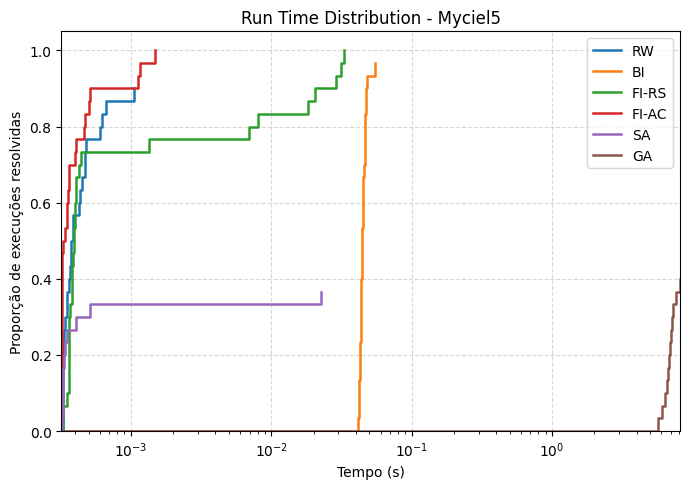

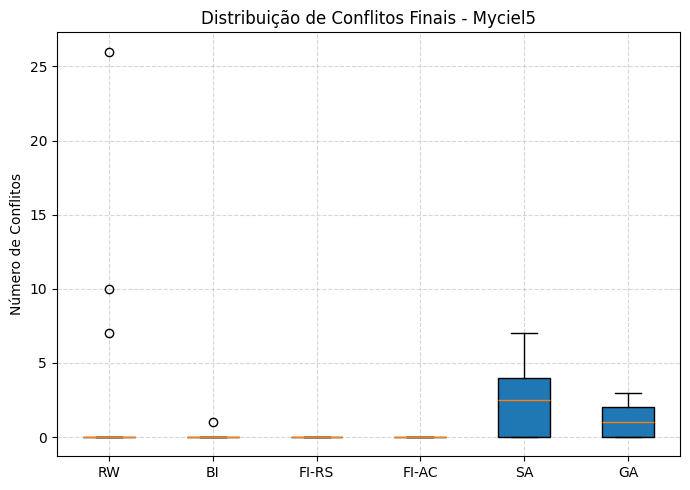

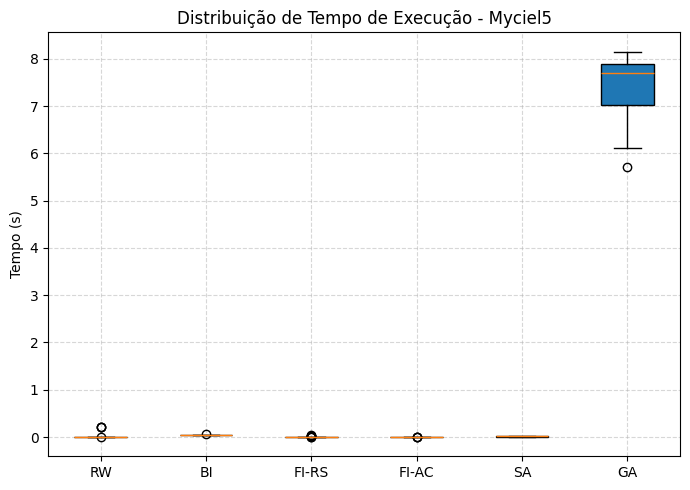


=== Estatísticas de Desempenho (Myciel5) ===
RW     | Conflitos médios:   1.43 ±  5.04 | Tempo médio:  0.021s ± 0.062
BI     | Conflitos médios:   0.03 ±  0.18 | Tempo médio:  0.045s ± 0.003
FI-RS  | Conflitos médios:   0.00 ±  0.00 | Tempo médio:  0.005s ± 0.010
FI-AC  | Conflitos médios:   0.00 ±  0.00 | Tempo médio:  0.000s ± 0.000
SA     | Conflitos médios:   2.30 ±  2.15 | Tempo médio:  0.019s ± 0.013
GA     | Conflitos médios:   0.97 ±  0.95 | Tempo médio:  7.450s ± 0.627


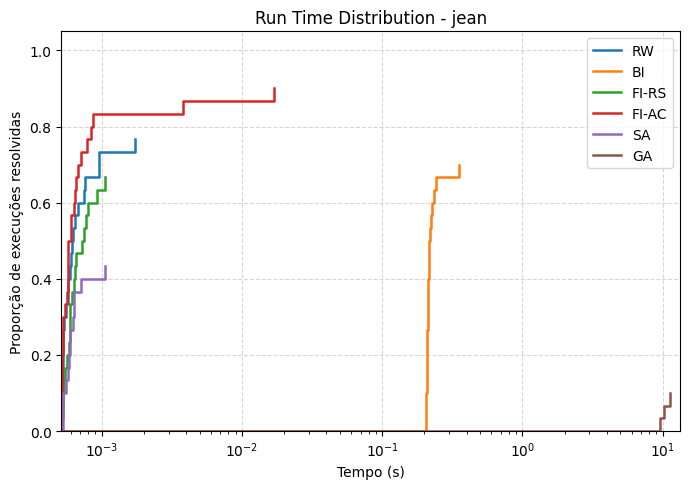

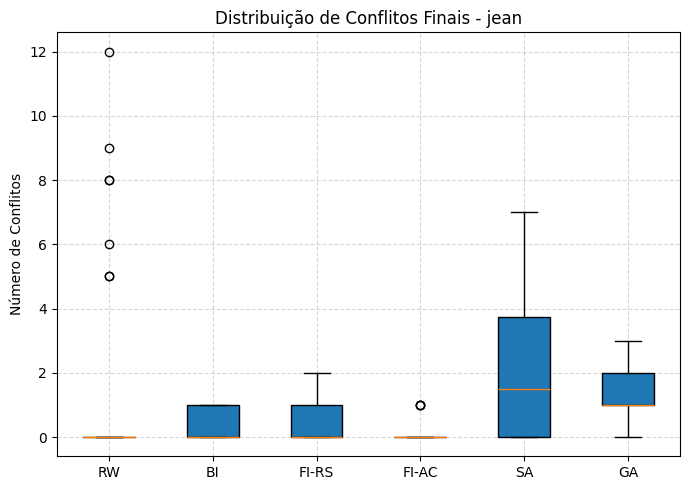

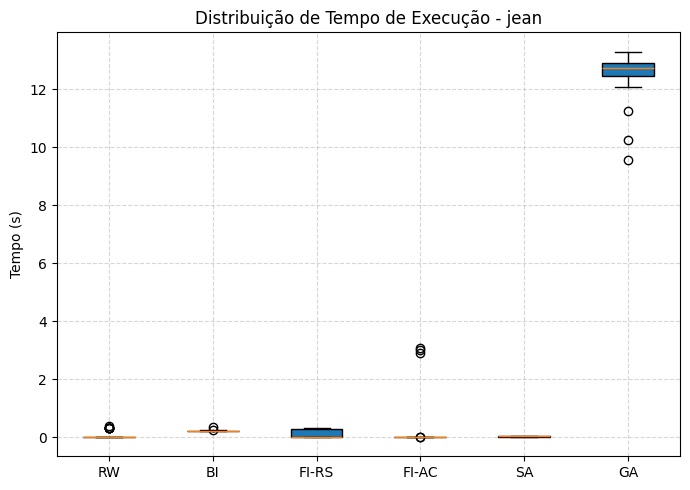


=== Estatísticas de Desempenho (jean) ===
RW     | Conflitos médios:   1.77 ±  3.39 | Tempo médio:  0.073s ± 0.132
BI     | Conflitos médios:   0.30 ±  0.46 | Tempo médio:  0.220s ± 0.026
FI-RS  | Conflitos médios:   0.37 ±  0.55 | Tempo médio:  0.099s ± 0.139
FI-AC  | Conflitos médios:   0.10 ±  0.30 | Tempo médio:  0.300s ± 0.898
SA     | Conflitos médios:   1.97 ±  2.17 | Tempo médio:  0.027s ± 0.023
GA     | Conflitos médios:   1.53 ±  0.92 | Tempo médio: 12.518s ± 0.803


In [20]:
num_execucoes = 30
max_iter = 1000

heuristicas = {
    "RW": random_walk,
    "BI": best_improvement,
    "FI-RS": first_improvement_rs,
    "FI-AC": first_improvement_ac,
    "SA": simulated_annealing,
    "GA": algoritmo_genetico
}

def testar_heuristicas(grafo, cores, nome):
    resultados = {h: [] for h in heuristicas}
    tempos = {h: [] for h in heuristicas}

    for h_nome, func in heuristicas.items():
        for _ in range(num_execucoes):
            coloracao_inicial = gerar_coloracao_aleatoria(grafo, cores, greedy=True)
            inicio = time.time()
            if h_nome == "GA":
                coloracao, conflitos = func(grafo, 20, 100, cores, 0.05, 35, 0.95)
            elif h_nome == "SA":
                coloracao, conflitos = func(grafo, coloracao_inicial, cores, max_iter, 10, 0.9)
            else:
                coloracao, conflitos = func(grafo, coloracao_inicial, cores, max_iter)
            fim = time.time()
            resultados[h_nome].append(conflitos)
            tempos[h_nome].append(fim - inicio)

    plt.figure(figsize=(7, 5))
    max_time_global = max((t for h in heuristicas for t in tempos[h]), default=1.0)
    min_time_global = min((t for h in heuristicas for t in tempos[h] if t > 0), default=1e-6)
    for h_nome in heuristicas:
        tempos_resolvidos = [t for (t, c) in zip(tempos[h_nome], resultados[h_nome]) if c == 0]
        if len(tempos_resolvidos) > 0:
            tempos_sorted = np.sort(tempos_resolvidos)
            proporcao = np.arange(1, len(tempos_sorted) + 1) / len(tempos[h_nome])
            tempos_plot = np.concatenate(([1e-12], tempos_sorted))
            proporcao_plot = np.concatenate(([0.0], proporcao))
        else:
            tempos_plot = np.array([1e-12, max_time_global])
            proporcao_plot = np.array([0.0, 0.0])
        plt.step(tempos_plot, proporcao_plot, where="post", label=h_nome, linewidth=1.8)
    plt.xscale("log")
    plt.xlim(min_time_global, max_time_global)
    plt.ylim(0, 1.05)
    plt.title(f"Run Time Distribution - {nome}")
    plt.xlabel("Tempo (s)")
    plt.ylabel("Proporção de execuções resolvidas")
    plt.legend(loc="best", frameon=True, shadow=False)
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(7, 5))
    plt.boxplot([resultados[h] for h in heuristicas], tick_labels=list(heuristicas.keys()), patch_artist=True)
    plt.title(f"Distribuição de Conflitos Finais - {nome}")
    plt.ylabel("Número de Conflitos")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(7, 5))
    plt.boxplot([tempos[h] for h in heuristicas], tick_labels=list(heuristicas.keys()), patch_artist=True)
    plt.title(f"Distribuição de Tempo de Execução - {nome}")
    plt.ylabel("Tempo (s)")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()

    print(f"\n=== Estatísticas de Desempenho ({nome}) ===")
    for h_nome in heuristicas:
        med_confl = np.mean(resultados[h_nome])
        std_confl = np.std(resultados[h_nome])
        med_tempo = np.mean(tempos[h_nome])
        std_tempo = np.std(tempos[h_nome])
        print(f"{h_nome:<6} | Conflitos médios: {med_confl:6.2f} ± {std_confl:5.2f} | Tempo médio: {med_tempo:6.3f}s ± {std_tempo:5.3f}")

testar_heuristicas(grafo_myciel5, cores_myciel5, "Myciel5")
testar_heuristicas(grafo_jean, cores_jean, "jean")


### Heuristica DSATUR

In [21]:
def dsatur(grafo, cores):
    coloracao = {}
    vertices = list(grafo.graph.keys())
    graus = {v: grafo.out_degree(v) for v in vertices}
    saturacao = {v: 0 for v in vertices}
    nao_coloridos = set(vertices)

    vertice_atual = max(vertices, key=lambda v: graus[v])
    coloracao[vertice_atual] = cores[0]
    nao_coloridos.remove(vertice_atual)

    while nao_coloridos:
        for v in nao_coloridos:
            vizinhos = grafo.get_neighbors(v)
            cores_vizinhos = {coloracao[u] for u in vizinhos if u in coloracao}
            saturacao[v] = len(cores_vizinhos)

        vertice_atual = max(nao_coloridos, key=lambda v: (saturacao[v], graus[v]))
        vizinhos = grafo.get_neighbors(vertice_atual)
        cores_vizinhos = {coloracao[u] for u in vizinhos if u in coloracao}

        cor_disponivel = next((cor for cor in cores if cor not in cores_vizinhos),min(cores, key=lambda c: sum(1 for u in vizinhos if coloracao.get(u) == c)))
        coloracao[vertice_atual] = cor_disponivel
        nao_coloridos.remove(vertice_atual)

    conflitos = contar_conflitos(grafo, coloracao)
    return coloracao, conflitos


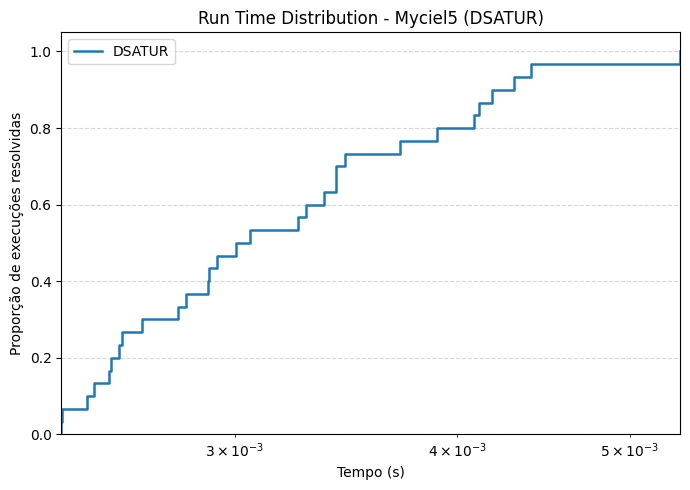

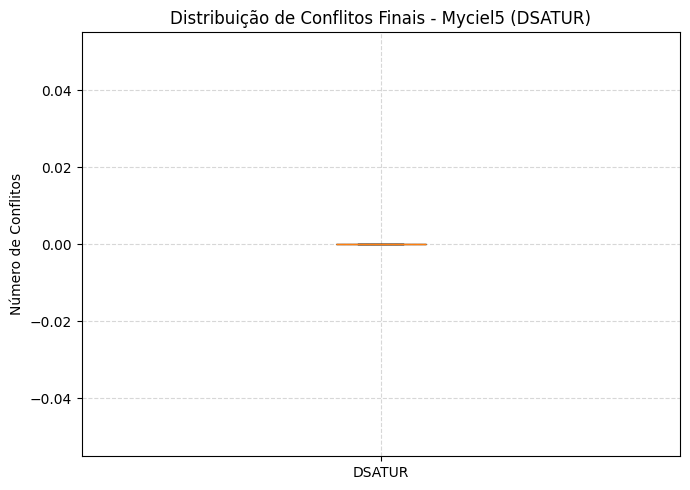

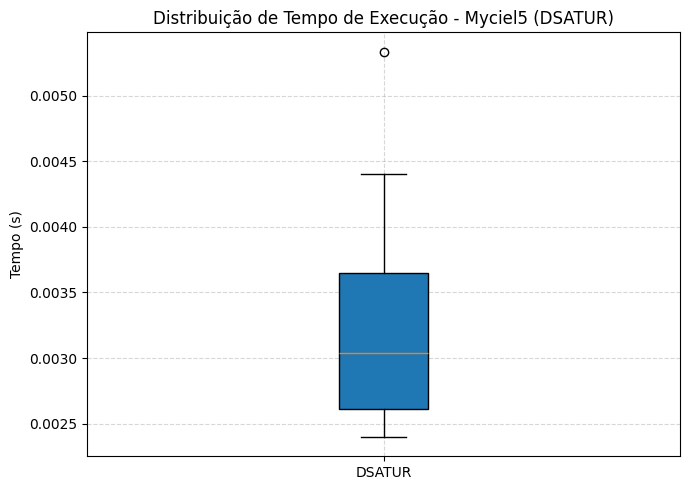


=== Estatísticas de Desempenho (DSATUR - Myciel5) ===
Conflitos médios: 0.00 ± 0.00
Tempo médio: 0.00325s ± 0.00072


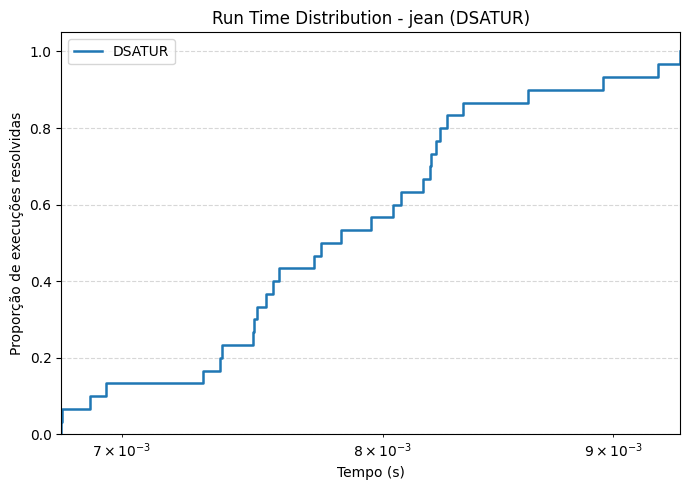

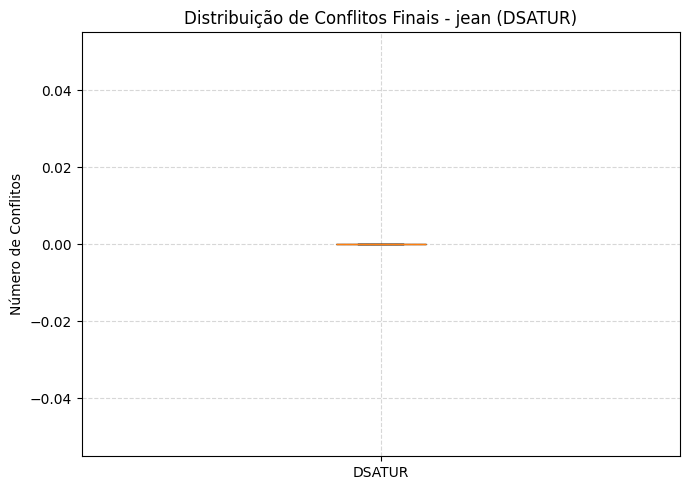

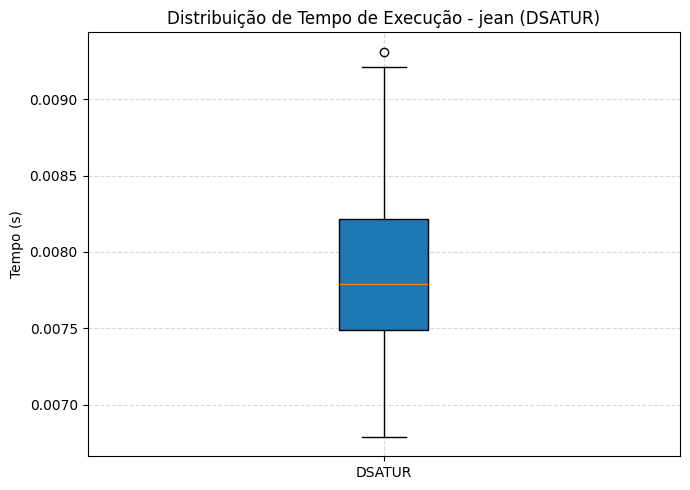


=== Estatísticas de Desempenho (DSATUR - jean) ===
Conflitos médios: 0.00 ± 0.00
Tempo médio: 0.00786s ± 0.00064


In [22]:
def testar_dsatur(grafo, cores, nome):
    resultados = []
    tempos = []
    num_execucoes = 30

    for _ in range(num_execucoes):
        inicio = time.time()
        coloracao, conflitos = dsatur(grafo, cores)
        fim = time.time()
        resultados.append(conflitos)
        tempos.append(fim - inicio)

    plt.figure(figsize=(7, 5))
    max_time = max(tempos) if tempos else 1.0
    min_time = min([t for t in tempos if t > 0], default=1e-6)
    tempos_resolvidos = [t for (t, c) in zip(tempos, resultados) if c == 0]
    if len(tempos_resolvidos) > 0:
        tempos_sorted = np.sort(tempos_resolvidos)
        proporcao = np.arange(1, len(tempos_sorted) + 1) / len(tempos)
        tempos_plot = np.concatenate(([1e-12], tempos_sorted))
        proporcao_plot = np.concatenate(([0.0], proporcao))
    else:
        tempos_plot = np.array([1e-12, max_time])
        proporcao_plot = np.array([0.0, 0.0])
    plt.step(tempos_plot, proporcao_plot, where="post", label="DSATUR", linewidth=1.8)
    plt.xscale("log")
    plt.xlim(min_time, max_time)
    plt.ylim(0, 1.05)
    plt.title(f"Run Time Distribution - {nome} (DSATUR)")
    plt.xlabel("Tempo (s)")
    plt.ylabel("Proporção de execuções resolvidas")
    plt.legend(loc="best", frameon=True, shadow=False)
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(7, 5))
    plt.boxplot([resultados], tick_labels=["DSATUR"], patch_artist=True)
    plt.title(f"Distribuição de Conflitos Finais - {nome} (DSATUR)")
    plt.ylabel("Número de Conflitos")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(7, 5))
    plt.boxplot([tempos], tick_labels=["DSATUR"], patch_artist=True)
    plt.title(f"Distribuição de Tempo de Execução - {nome} (DSATUR)")
    plt.ylabel("Tempo (s)")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()

    med_confl = np.mean(resultados)
    std_confl = np.std(resultados)
    med_tempo = np.mean(tempos)
    std_tempo = np.std(tempos)

    print(f"\n=== Estatísticas de Desempenho (DSATUR - {nome}) ===")
    print(f"Conflitos médios: {med_confl:.2f} ± {std_confl:.2f}")
    print(f"Tempo médio: {med_tempo:.5f}s ± {std_tempo:.5f}")


testar_dsatur(grafo_myciel5, cores_myciel5, "Myciel5")
testar_dsatur(grafo_jean, cores_jean, "jean")
